In [2]:
import pandas as pd 
import numpy as np

In [3]:
data=pd.read_csv("C:\\Users\\lSS\\Downloads\\Fraud.csv")

In [4]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Analysing

In [5]:
data.isnull().values.any()

False

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
print("Number of Real transactions: ", len(data[data.isFraud == 0]))
print("Number of Fraud transactions: ", len(data[data.isFraud == 1]))


Number of Real transactions:  6354407
Number of Fraud transactions:  8213


VISUALISING

In [8]:
import seaborn as sns

In [9]:
import matplotlib.pyplot as plt

In [10]:
corr=data.corr()

<AxesSubplot:>

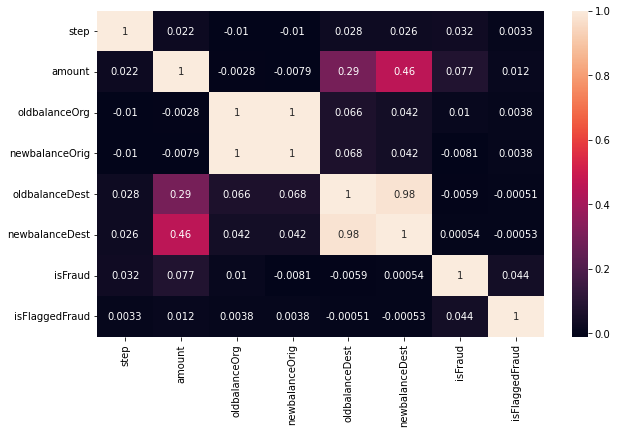

In [11]:
plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)

In [12]:
new_data=data.copy()

In [13]:
objects=new_data.select_dtypes(include='object').columns
print(objects)

Index(['type', 'nameOrig', 'nameDest'], dtype='object')


Label encoding has to be performed in order to check multicollinearlity 

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for i in objects:
    new_data[i] = le.fit_transform(new_data[i].astype(str))

print (new_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int32  
 2   amount          float64
 3   nameOrig        int32  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int32  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int32(3), int64(3)
memory usage: 461.2 MB
None


In [15]:
new_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


In [16]:
# Import library for VIF (VARIANCE INFLATION FACTOR)

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(data):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = data.columns
    vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

    return(vif)

calc_vif(new_data)

,variables,VIF
0,step,2.791610
1,type,4.467405
2,amount,4.149312
3,nameOrig,2.764234
4,oldbalanceOrg,576.803777
5,newbalanceOrig,582.709128
6,nameDest,3.300975
7,oldbalanceDest,73.349937
8,newbalanceDest,85.005614
9,isFraud,1.195305


We can see that oldbalanceOrg and newbalanceOrig have too high VIF thus they are highly correlated. Similarly oldbalanceDest and newbalanceDest. Also nameDest is connected to nameOrig.Let's combine pairs of collinear attributes and drop the individual ones

In [20]:
new_data['Actual_amount_orig']=new_data.apply(lambda x:x['oldbalanceOrg']-x['newbalanceOrig'],axis=1)

In [21]:
new_data['Actual_amount_dest'] = new_data.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
new_data['TransactionPath'] = new_data.apply(lambda x: x['nameOrig'] + x['nameDest'],axis=1)

#Dropping columns
new_data = new_data.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step','nameOrig','nameDest'],axis=1)

calc_vif(new_data)


,variables,VIF
0,type,2.687803
1,amount,3.818902
2,isFraud,1.184479
3,isFlaggedFraud,1.002546
4,Actual_amount_orig,1.307910
5,Actual_amount_dest,3.754335
6,TransactionPath,2.677167


<AxesSubplot:>

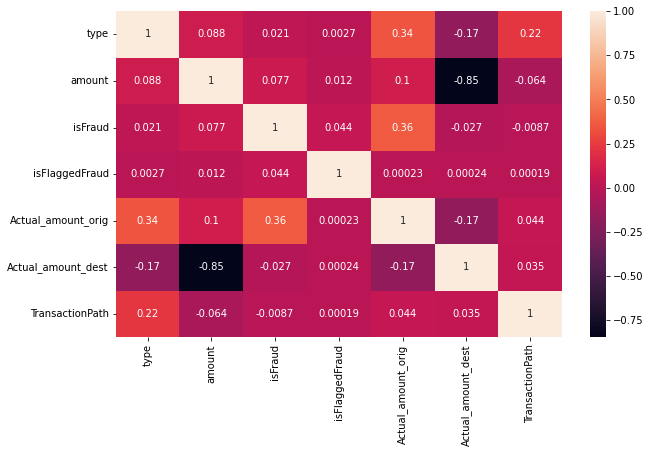

In [22]:
corr=new_data.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)

How did you select variables to be included in the model?
Using the VIF values and correlation heatmap. We just need to check if there are any two attributes highly correlated to each other and then drop the one which is less correlated to the isFraud Attribute.

# MODEL BUILDING

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import itertools
from collections import Counter
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [24]:
# Perform Scaling
scaler = StandardScaler()
new_data["NormalizedAmount"] = scaler.fit_transform(new_data["amount"].values.reshape(-1, 1))
new_data.drop(["amount"], inplace= True, axis= 1)

Y = new_data["isFraud"]
X = new_data.drop(["isFraud"], axis= 1)

In [25]:
# Split the data
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size= 0.3, random_state= 42)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)


Shape of X_train:  (4453834, 6)
Shape of X_test:  (1908786, 6)


In [26]:
# DECISION TREE

dt = DecisionTreeClassifier()
dt.fit(X_train, Y_train)

Y_pred_dt = dt.predict(X_test)
decision_tree_score = dt.score(X_test, Y_test) * 100

Evaluation

In [27]:
print("Decision Tree Score: ", decision_tree_score)


Decision Tree Score:  99.92345920391286


In [28]:
print("TP,FP,TN,FN - Decision Tree")
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_dt).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

TP,FP,TN,FN - Decision Tree
True Positives: 1719
False Positives: 745
True Negatives: 1905606
False Negatives: 716


In [29]:
confusion_matrix_dt = confusion_matrix(Y_test, Y_pred_dt.round())
print("Confusion Matrix - Decision Tree")
print(confusion_matrix_dt,)

Confusion Matrix - Decision Tree
[[1905606     745]
 [    716    1719]]


In [30]:
classification_report_dt = classification_report(Y_test, Y_pred_dt)
print("Classification Report - Decision Tree")
print(classification_report_dt)


Classification Report - Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.70      0.71      0.70      2435

    accuracy                           1.00   1908786
   macro avg       0.85      0.85      0.85   1908786
weighted avg       1.00      1.00      1.00   1908786



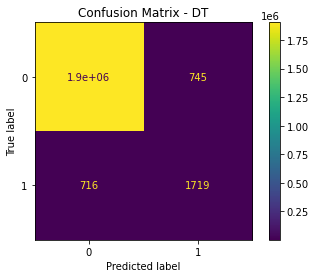

In [31]:
# visualising confusion matrix - DT


disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt)
disp.plot()
plt.title('Confusion Matrix - DT')
plt.show()

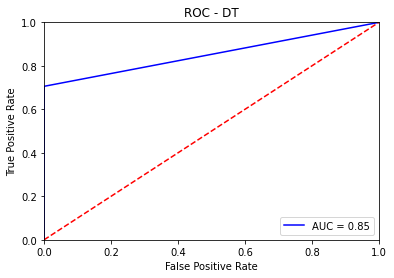

In [32]:
# AUC ROC - DT
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_pred_dt)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - DT')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

What are the key factors that predict fraudulent customer?

The source of request is secured or not ?
Is the name of organisation asking for money is legit or not ?
Transaction history of vendors.
What kind of prevention should be adopted while company update its infrastructure?

Use smart vertified apps only.
Browse through secured websites.
Use secured internet connections (USE VPN).
Keep your mobile and laptop security updated.
Don't respond to unsolicited calls/SMS(s/E-mails.
If you feel like you have been tricked or security compromised, contact your bank immidiately.
Assuming these actions have been implemented, how would you determine if they work?

Bank sending E-statements.
Customers keeping a check of their account activity.
Always keep a log of your payments.
